In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR,LinearSVR, OneClassSVM, NuSVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor


from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function returns SOC value
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+3)
    if kernel == 'linear':
        return sp*(2*p+1)
    if kernel == 'poly':
        return sp*(2*p+3+2)
    
    return sp*(2*p+12)

#custom metric based on SOC
def soc_metric(model,*args,**kwargs):
  X,y=args
  return -get_soc(model.kernel,len(model.support_vectors_),X.shape[1])

In [3]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
columns = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']

df = pd.read_csv(uploaded)
df[['day','month']] = OrdinalEncoder().fit_transform(df[['day','month']])
print(df.shape)
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
skewness,0.036246,0.417296,0.084074,0.157756,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344,12.846934
kurtosis,-1.172331,1.420553,-1.719350,-1.101004,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964,194.140721


In [4]:
#scale independent variables
df[columns]=StandardScaler().fit_transform(df[columns])
print(df.shape)
z = np.abs(zscore(df))
df = df[(z < 3).all(axis=1)]

print(df.shape)
df.head()

(517, 13)
(486, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1.008313,0.569860,0.284222,-1.423121,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,0.0
1,1.008313,-0.244001,0.970871,1.176715,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,0.0
2,1.008313,-0.244001,0.970871,-0.383187,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,0.0
5,1.440925,1.383722,-1.089076,0.136781,0.300161,-0.399665,-0.241863,1.246598,0.570734,-0.937830,0.772325,-0.073268,0.0
6,1.440925,1.383722,-1.089076,-0.903154,0.300161,-0.343401,-0.211197,-0.114524,0.898263,-1.060516,-0.512650,-0.073268,0.0


In [5]:
X_orig = df[columns]
y = df['area']

In [6]:
outliers = LocalOutlierFactor(20).fit_predict(X_orig)
target_out = LocalOutlierFactor(20).fit_predict(y.values.reshape(-1,1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(468, 12)

In [7]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = X_orig.columns
vif

,VIF Factor,features
0,1.373100,X
1,1.379897,Y
2,1.560588,month
3,1.062431,day
4,3.162789,FFMC
5,2.752483,DMC
6,2.760612,DC
7,2.520955,ISI
8,2.898281,temp
9,1.913867,RH


In [8]:
X=X_orig[:]
# X = SelectKBest(f_regression, k=10).fit_transform(X_orig, y)
print(X[:10])
# X_orig.head()

           X         Y     month       day      FFMC       DMC        DC  \
0   1.008313  0.569860  0.284222 -1.423121 -0.805959 -1.323326 -1.830477   
1   1.008313 -0.244001  0.970871  1.176715 -0.008102 -1.179541  0.488891   
2   1.008313 -0.244001  0.970871 -0.383187 -0.008102 -1.049822  0.560715   
5   1.440925  1.383722 -1.089076  0.136781  0.300161 -0.399665 -0.241863   
6   1.440925  1.383722 -1.089076 -0.903154  0.300161 -0.343401 -0.211197   
7   1.440925  1.383722 -1.089076 -0.903154  0.155096  0.539625  0.243154   
8   1.440925  1.383722  1.199754  1.176715  0.064430  0.291128  0.583715   
9   1.008313  0.569860  1.199754 -0.383187  0.336427 -0.357467  0.607926   
10  1.008313  0.569860  1.199754 -0.383187  0.336427 -0.357467  0.607926   
11  1.008313  0.569860  1.199754 -0.383187  0.390827 -0.588773  0.666031   

         ISI      temp        RH      wind      rain  
0  -0.860946 -1.842640  0.411724  1.498614 -0.073268  
1  -0.509688 -0.153278 -0.692456 -1.741756 -0.073268 

In [9]:
k=X.shape[1]

acc_metric = 'neg_mean_squared_error'
acc_metric = 'neg_mean_absolute_error'

cv = KFold(n_splits=10, shuffle= True,random_state=100)

model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

X.shape

(468, 12)

In [10]:
model=LinearRegression()
mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)

MSE:  6.723161239177527 STD:  0.7877357355605523


Best Hyperparameters::
{'C': 0.0001, 'kernel': 'linear'}
SOC:  11650
MSE:  5.222627727410509 STD:  1.2484885472435723


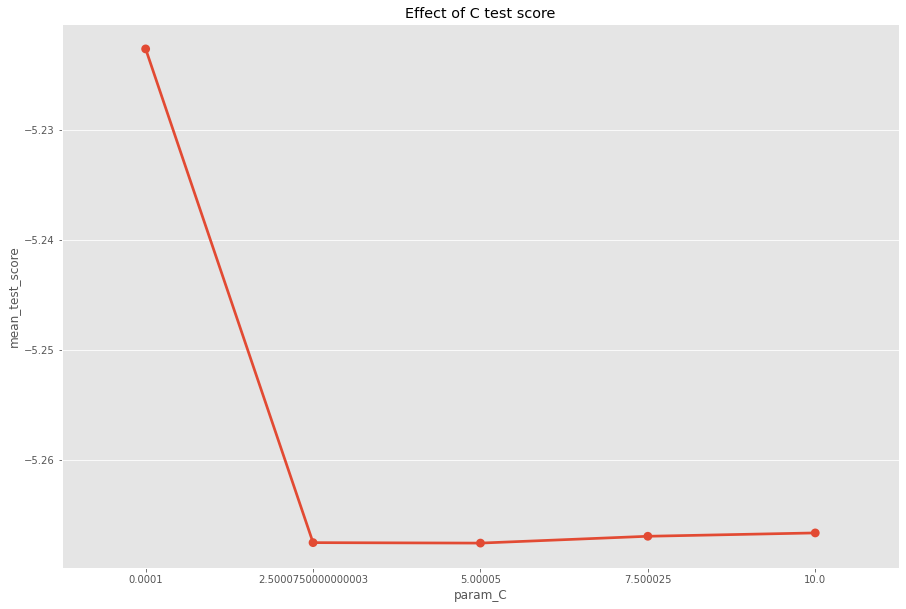

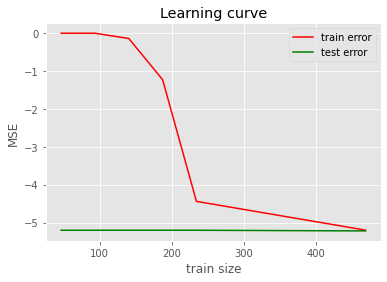

In [11]:
params = {'C':np.linspace(0.0001,10,5),
          'kernel':['linear']}

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C test score")


svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+1))

mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
    
    
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [223]:
minRMSE=5.147283478995644
minRMSE,minRMSE*1.1

(5.147283478995644, 5.662011826895209)

min SOC:  462  corresponding Error:  5.208041987127939
min C:  3.334  min gamma:  0.1


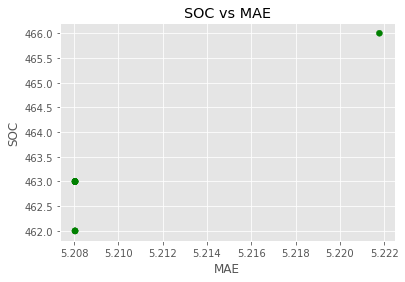

In [191]:
k=X.shape[1]
min_soc = 1000000
min_gamma=100000
min_c = 100000
socs = np.array([])
mses=np.array([])
colors=np.array([])
minErr=100000

for C in np.linspace(0.001,10,10):
    model = SVR(C=C,kernel='linear')
    model.fit(X,y)
    soc = len(model.support_vectors_)*(2*k+1)
    socs = np.append(socs,soc)
    mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
    mse=np.abs(np.mean(mse))
    mses = np.append(mses,mse)
    if mse > minRMSE*1.1:
        colors=np.append(colors,'red')
    else:
        colors=np.append(colors,'green')
    if min_soc >= soc:
        min_soc = soc
        min_gamma = gamma
        min_c = C
        min_err=mse
plt.title('SOC vs MAE')
plt.scatter(mses,socs,c=colors)
plt.xlabel('MAE')
plt.ylabel('SOC')
print('min SOC: ',min_soc,' corresponding Error: ',min_err)
print('min C: ',min_c,' min gamma: ',min_gamma)
plt.show()

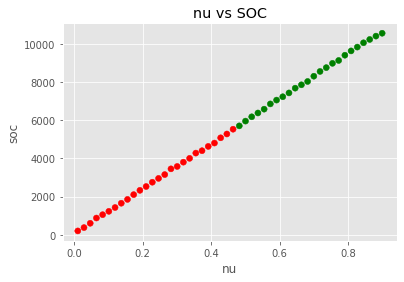

In [16]:
# best model in MSE: 
# model=NuSVR(nu=0.3,C=1.68100537200059, gamma = 0.1,degree=3,kernel='poly') #104.38
# model=NuSVR(nu=0.24,C=16.68100537200059, gamma = 0.1,kernel='linear') #104.60
# best model in SOC: 
# model=NuSVR(nu=0.185,C=2.15, gamma = 0.1,kernel='linear')# 3013
# model=NuSVR(nu=0.173,C=1.68100537200059, gamma = 0.1,degree=3,kernel='poly') #3354
# model=NuSVR(nu=0.1545,C=16.68100537200059, gamma = 0.1,kernel='rbf') #5624
# model=NuSVR(nu=0.185,C=16.68100537200059, gamma = 0.1,kernel='linear')# 3772
# model=NuSVR(nu=0.185,C=2.15, gamma = 0.1,kernel='linear')# 

nu_range = np.linspace(0.01,0.9,50)
socs = []
mses = []
nus = []

for nu in nu_range:
    model = NuSVR(nu=nu,C=0.0001 , kernel='linear')
    mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)

    std=np.std(mse)
    mse=np.abs(np.mean(mse))
    
    model.fit(X,y)
    socs.append(model.n_support_[0]*(2*k+1))
    mses.append(mse)
    nus.append(nu)

colors = []
for mse in mses:
    if mse > minRMSE * 1.1:
        colors.append('red')
    else:
        colors.append('green')
        
plt.title("nu vs SOC")
plt.scatter(nus,socs,c=colors)
plt.xlabel('nu')
plt.ylabel('soc')
plt.show()

In [18]:
mses=np.asarray(mses)
socs=np.asarray(socs)
mask=mses <= minRMSE * 1.15
print(mses[mask])
print(socs[mask])
print(nu_range[mask])

[5.99936764 5.9118385  5.86561523 5.81548757 5.77395957 5.72538506
 5.6851497  5.62313412 5.59087105 5.53319627 5.47850868 5.42234382
 5.37941906 5.34682691 5.32546842 5.30440312 5.28737272 5.27035846
 5.25759099 5.24522775 5.23899285 5.23391651 5.23121782 5.22360306
 5.22025919 5.21823274 5.21669835 5.21513367 5.21187886]
[ 4625  4800  5075  5275  5525  5700  5950  6175  6375  6575  6850  7050
  7225  7425  7675  7850  8025  8300  8550  8750  8975  9125  9400  9625
  9825 10050 10225 10400 10550]
[0.39142857 0.40959184 0.4277551  0.44591837 0.46408163 0.4822449
 0.50040816 0.51857143 0.53673469 0.55489796 0.57306122 0.59122449
 0.60938776 0.62755102 0.64571429 0.66387755 0.68204082 0.70020408
 0.71836735 0.73653061 0.75469388 0.77285714 0.79102041 0.80918367
 0.82734694 0.8455102  0.86367347 0.88183673 0.9       ]


In [22]:
5.21187886*1.15

5.9936606889999995

Best Hyperparameters: 
{'C': 4.641588833612779, 'gamma': 0.05994842503189409, 'kernel': 'rbf'}
# SV 450
SOC:  17550
MSE:  5.147283478995644 STD:  1.1652446502495057


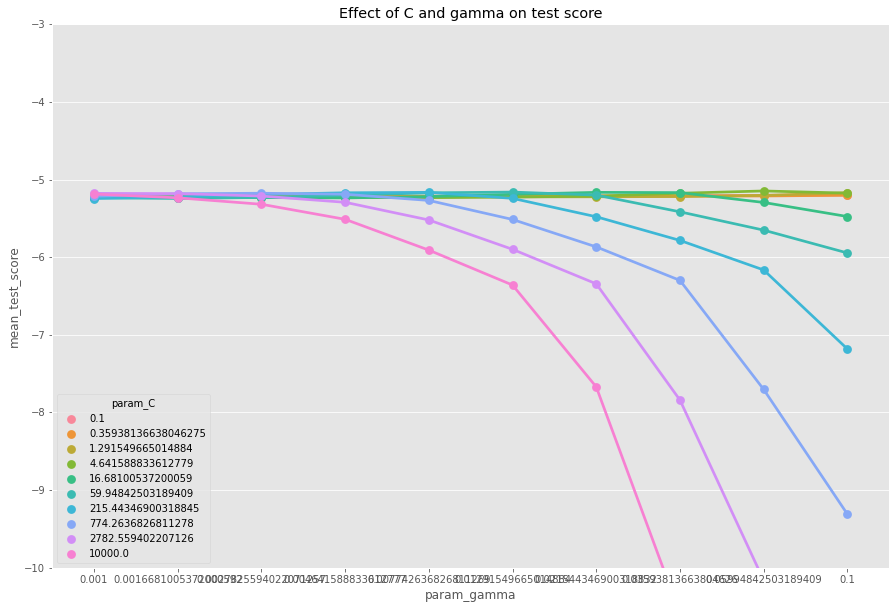

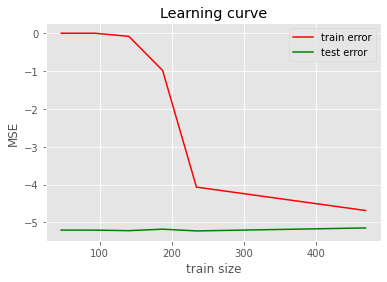

In [20]:
# params = {'C':np.logspace(-1,4,10),
#           'gamma':np.logspace(-3,-1,10),
#           'kernel':['rbf']}
params = {'C':np.logspace(-1,4,10),
          'gamma':np.logspace(-3,-1,10),
          'kernel':['rbf']}

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)

print('Best Hyperparameters: \n{}'.format(gcv.best_params_))

results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-10,-3])
sns.pointplot(data=results[['mean_test_score','param_C','param_gamma']],
              y='mean_test_score',x='param_gamma',
              hue='param_C',
              ax=ax)

ax.set(title='Effect of C and gamma on test score')


svr=gcv.best_estimator_

print('# SV',len(svr.support_vectors_))
print('SOC: ',len(svr.support_vectors_)*(3*k+3))



mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print('MSE: ',mse,'STD: ',std)
plt.show()

if mse < minRMSE:
    minRMSE=mse
    model_selected=svr

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title('Learning curve')
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [110]:
minRMSE=5.147283478995644
minRMSE,minRMSE*1.1

(5.147283478995644, 5.662011826895209)

min SOC:  13640  corresponding Error:  5.154071747898295
min C:  16.68100537200059  min gamma:  0.03593813663804626


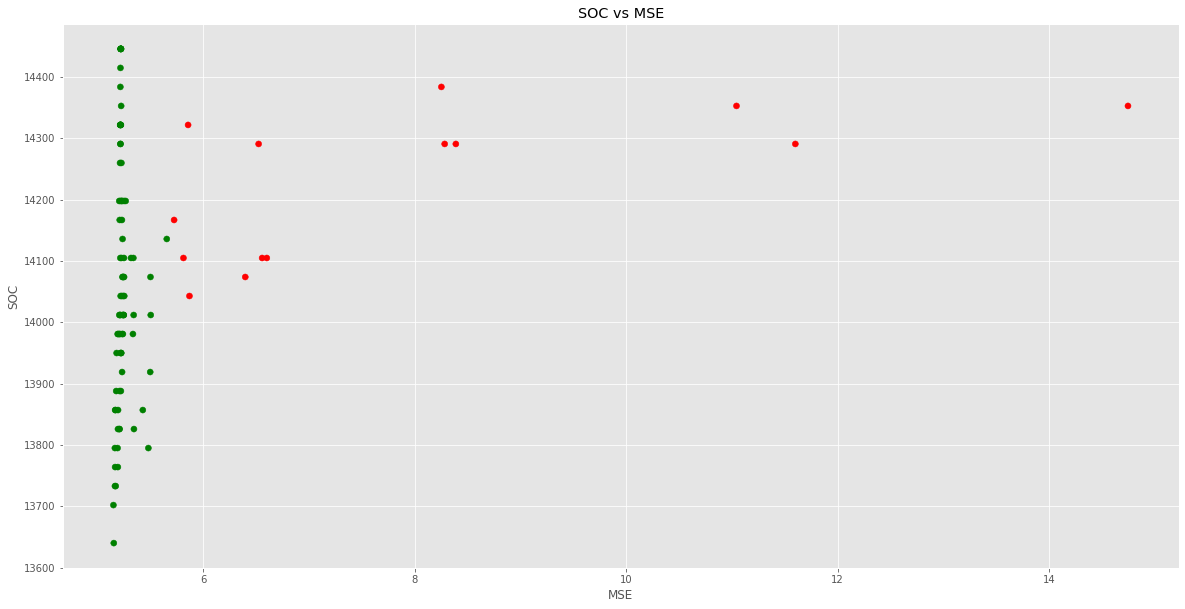

In [55]:
plt.figure(figsize=(20,10))

k=X.shape[1]

gammas = np.logspace(-3,-1,10)

min_soc = 1000000
min_gamma=100000
min_c = 100000
socs = np.array([])
mses=np.array([])
colors=np.array([])
minErr=100000
for C in np.logspace(-1,4,10):
    for gamma in gammas:
        model = SVR(C=C,gamma=gamma,kernel='rbf')
        model.fit(X,y)
        soc = len(model.support_vectors_)*(3*k+3)
        socs = np.append(socs,soc)
        mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
        mse=np.abs(np.mean(mse))
        mses = np.append(mses,mse)
        if mse > minRMSE*1.1:
            colors=np.append(colors,'red')
        else:
            colors=np.append(colors,'green')
        if min_soc >= soc:
            min_soc = soc
            min_gamma = gamma
            min_c = C
            min_err=mse

            plt.title('SOC vs MSE')
plt.scatter(mses,socs,c=colors)
plt.xlabel('MSE')
plt.ylabel('SOC')
print('min SOC: ',min_soc,' corresponding Error: ',min_err)
print('min C: ',min_c,' min gamma: ',min_gamma)
plt.show()

In [56]:
13640/(3*k+1)

440.0

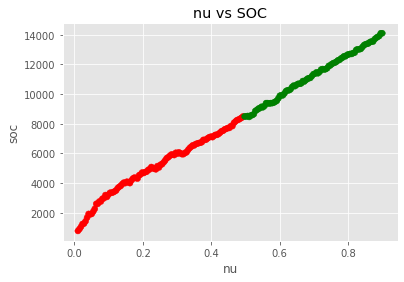

In [60]:
# best model in MSE: 
# model=NuSVR(nu=0.3,C=1.68100537200059, gamma = 0.1,degree=3,kernel='poly') #104.38
# model=NuSVR(nu=0.24,C=16.68100537200059, gamma = 0.1,kernel='linear') #104.60
# best model in SOC: 
# model=NuSVR(nu=0.185,C=2.15, gamma = 0.1,kernel='linear')# 3013
# model=NuSVR(nu=0.173,C=1.68100537200059, gamma = 0.1,degree=3,kernel='poly') #3354
# model=NuSVR(nu=0.1545,C=16.68100537200059, gamma = 0.1,kernel='rbf') #5624
# model=NuSVR(nu=0.185,C=16.68100537200059, gamma = 0.1,kernel='linear')# 3772
# model=NuSVR(nu=0.185,C=2.15, gamma = 0.1,kernel='linear')# 

nu_range = np.linspace(0.01,0.9,200)
socs = []
mses = []
nus = []

for nu in nu_range:
    model = NuSVR(nu=nu,C=4.641588833612779 , gamma=0.05994842503189409, kernel='rbf')
    mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)

    std=np.std(mse)
    mse=np.abs(np.mean(mse))
    
    model.fit(X,y)
    socs.append(model.n_support_[0]*(3*k+3))
    mses.append(mse)
    nus.append(nu)

colors = []
for mse in mses:
    if mse > minRMSE * 1.1:
        colors.append('red')
    else:
        colors.append('green')
        
plt.title("nu vs SOC")
plt.scatter(nus,socs,c=colors)
plt.xlabel('nu')
plt.ylabel('soc')
plt.show()

In [61]:
mses=np.asarray(mses)
socs=np.asarray(socs)
mask=mses <= minRMSE * 1.1
print(mses[mask])
print(socs[mask])
print(nu_range[mask])

[5.65321333 5.64070689 5.63015608 5.61533746 5.6010116  5.58549374
 5.57634684 5.5656417  5.54972226 5.53698154 5.51538131 5.49460282
 5.47546745 5.45943916 5.44987923 5.43868592 5.42540128 5.41649126
 5.40955004 5.39998567 5.38511441 5.37467829 5.36768355 5.35831531
 5.35014383 5.34078054 5.32899571 5.3177356  5.30850254 5.29967187
 5.29122389 5.28125938 5.27189516 5.26462199 5.25895243 5.25060549
 5.24061983 5.22901157 5.220635   5.21111615 5.20644956 5.20117169
 5.19542901 5.18997847 5.18538726 5.18214574 5.17862302 5.17544125
 5.17232789 5.16960045 5.16732723 5.1655219  5.16376853 5.16197935
 5.16009188 5.15801203 5.15619748 5.15406318 5.15210401 5.15046423
 5.1499005  5.14959266 5.14894318 5.14810603 5.1472752  5.14686151
 5.14622922 5.14616844 5.14596467 5.14574194 5.14637587 5.14749771
 5.14886878 5.15079324 5.15274383 5.15485572 5.1564599  5.15657082
 5.15592925 5.15513247 5.15470284 5.15459294 5.15441024 5.1543651
 5.15400924 5.15326373 5.15274989 5.15232446 5.15280765 5.15330

SV:  130
SOC:  2470
MSE:  8.28318754377768 STD:  0.48314924267659515


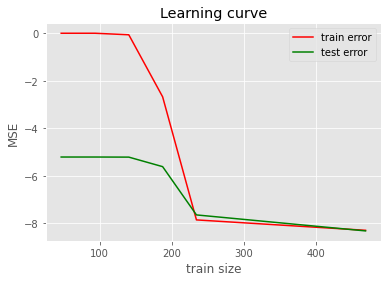

In [62]:
# best model in MSE: 
# model=NuSVR(nu=0.3,C=1.68100537200059, gamma = 0.1,degree=3,kernel='poly') #104.38
# model=NuSVR(nu=0.24,C=16.68100537200059, gamma = 0.1,kernel='linear') #104.60
# best model in SOC: 
# model=NuSVR(nu=0.185,C=2.15, gamma = 0.1,kernel='linear')# 3013
# model=NuSVR(nu=0.173,C=1.68100537200059, gamma = 0.1,degree=3,kernel='poly') #3354
# model=NuSVR(nu=0.1545,C=16.68100537200059, gamma = 0.1,kernel='rbf') #5624
# model=NuSVR(nu=0.185,C=16.68100537200059, gamma = 0.1,kernel='linear')# 3772
model=NuSVR(nu=0.185,C=2.15, gamma = 0.1,kernel='linear')# 

model.fit(X,y)
print("SV: ",len(model.support_vectors_))

print("SOC: ",len(model.support_vectors_)*(2*k+1)) #linear
# print("SOC: ",len(model.support_vectors_)*(3*k+3)) #rbf
# print("SOC: ",len(model.support_vectors_)*(2*k+4)) #poly and sigmoid


mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))

print("MSE: ",mse,"STD: ",std)
_,train_scores,test_scores=learning_curve(model,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [29]:
5624//(3*k+1)

152

Best Hyperparameters: 
{'C': 0.06, 'gamma': 278.2559402207126, 'kernel': 'sigmoid'}
SOC:  12038
MSE:  5.347402623774981 STD:  1.2519939301741307


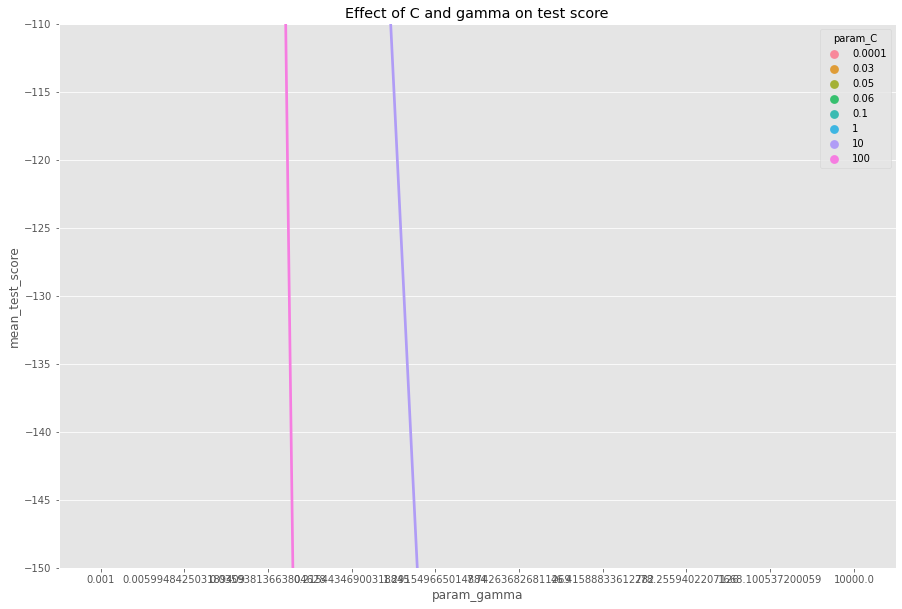

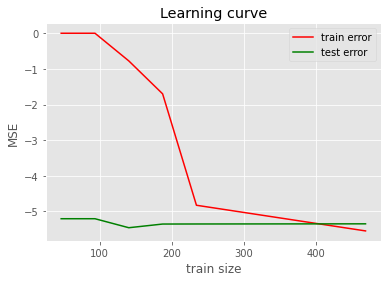

In [205]:
params = {'C':[0.0001,0.05,0.06,0.03,0.1,1,10,100],
          'gamma':np.logspace(-3,4,10),
          'kernel':['sigmoid',]}

gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters: \n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-150,-110])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")

svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+4))


mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
    
    
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

min SOC:  11752  corresponding Error:  5.308368955858237
min C:  0.05  min gamma:  1668.100537200059


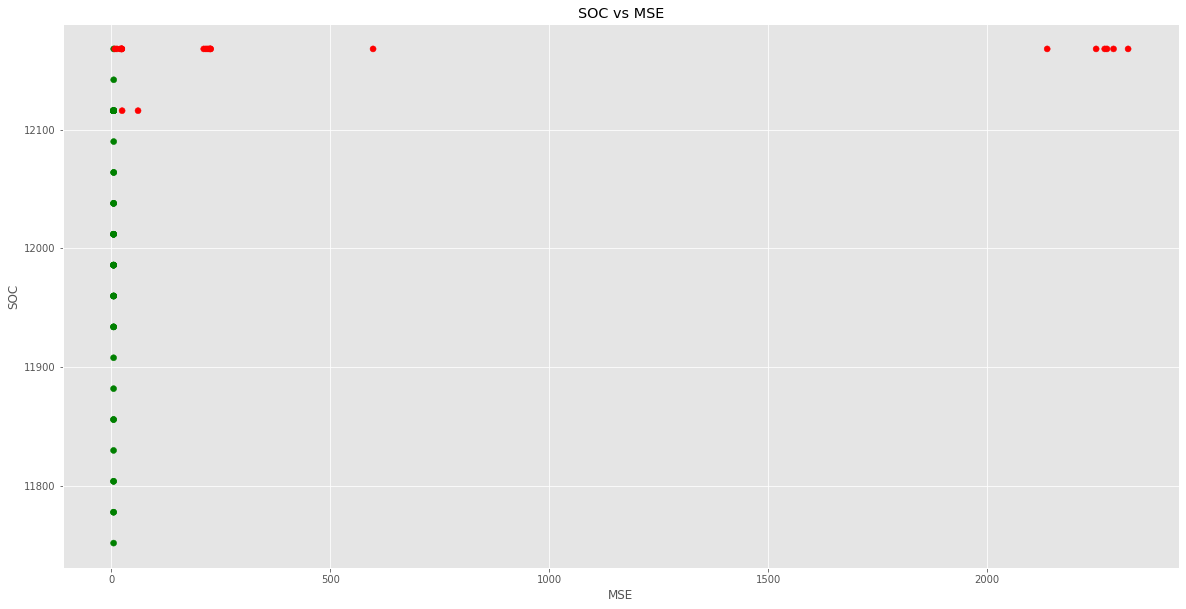

In [42]:
plt.figure(figsize=(20,10))

k=X.shape[1]

gammas = np.logspace(-3,4,10)

min_soc = 1000000
min_gamma=100000
min_c = 100000
socs = np.array([])
mses=np.array([])
colors=np.array([])
minErr=100000
for C in [0.0001,0.05,0.06,0.03,0.1,1,10,100]:
    for gamma in gammas:
        model = SVR(C=C,gamma=gamma,kernel='sigmoid')
        model.fit(X,y)
        soc = len(model.support_vectors_)*(2*k+4)
        socs = np.append(socs,soc)
        mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
        mse=np.abs(np.mean(mse))
        mses = np.append(mses,mse)
        if mse > minRMSE*1.1:
            colors=np.append(colors,'red')
        else:
            colors=np.append(colors,'green')
        if min_soc >= soc:
            min_soc = soc
            min_gamma = gamma
            min_c = C
            min_err=mse

            plt.title('SOC vs MSE')
plt.scatter(mses,socs,c=colors)
plt.xlabel('MSE')
plt.ylabel('SOC')
print('min SOC: ',min_soc,' corresponding Error: ',min_err)
print('min C: ',min_c,' min gamma: ',min_gamma)
plt.show()

Best Hyperparameters::
{'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
SOC:  11882
MSE:  119.41002402878064 STD:  38.85195387912459


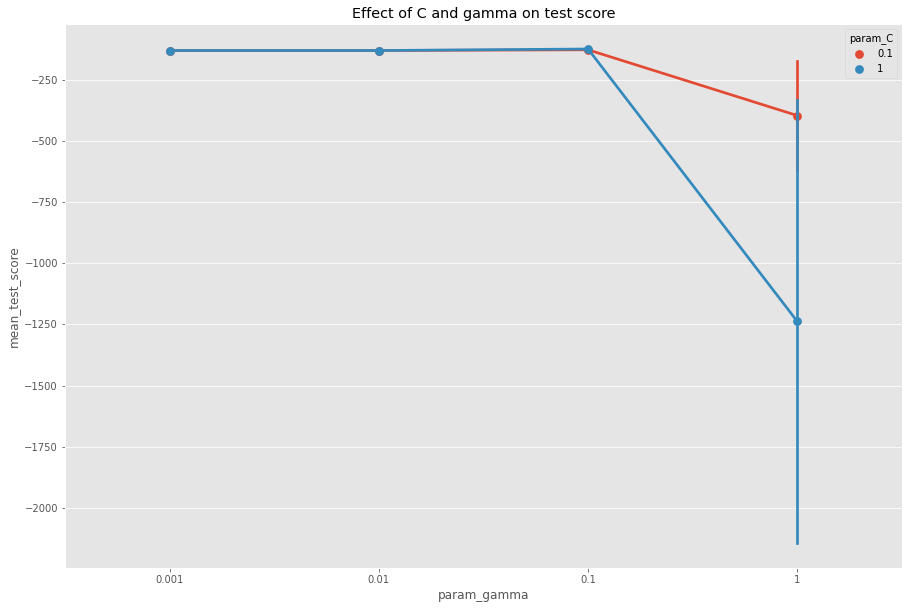

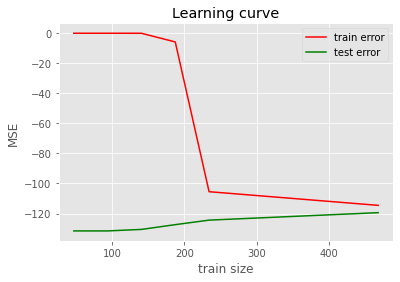

In [31]:
params = {'C':[0.1,1],
          'gamma':[0.001,0.01,0.1,1],
          'degree':[3,4],
          'kernel':['poly'],
         }


gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+4))


mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
    
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

min SOC:  11648  corresponding Error:  5.222131982188115
min C:  1  min gamma:  0.1


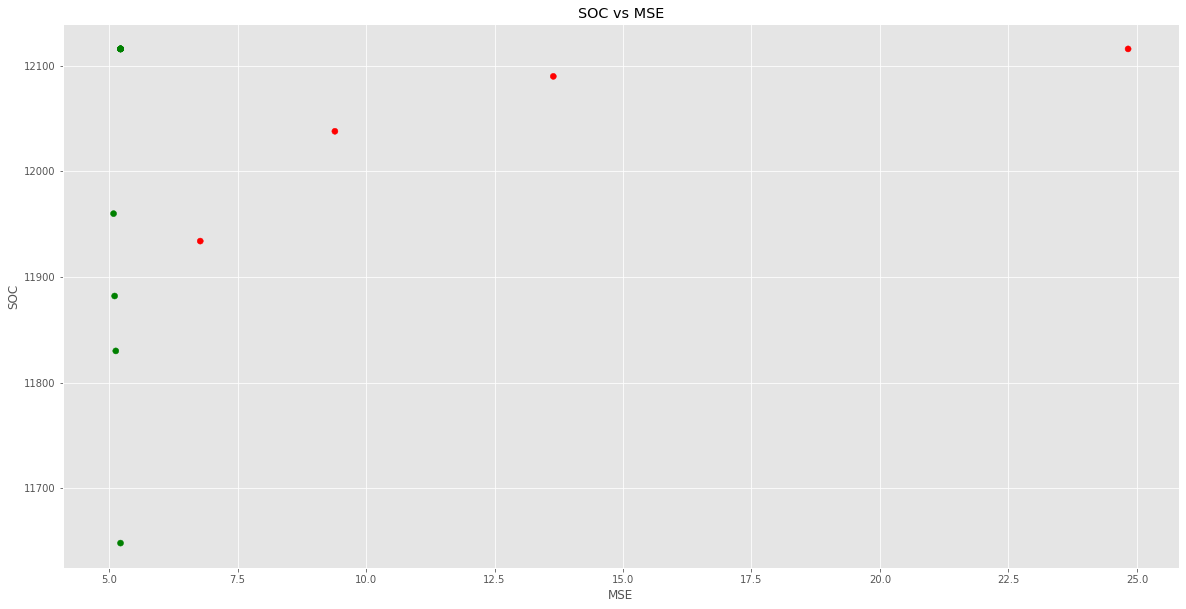

In [43]:
plt.figure(figsize=(20,10))

k=X.shape[1]

gammas = [0.001,0.01,0.1,1]

min_soc = 1000000
min_gamma=100000
min_c = 100000
socs = np.array([])
mses=np.array([])
colors=np.array([])
minErr=100000
for C in [0.1,1]:
    for gamma in gammas:
        for d in [3,4]:
            model = SVR(C=C,gamma=gamma,degree=d,kernel='poly')
            model.fit(X,y)
            soc = len(model.support_vectors_)*(2*k+4)
            socs = np.append(socs,soc)
            mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
            mse=np.abs(np.mean(mse))
            mses = np.append(mses,mse)
            if mse > minRMSE*1.1:
                colors=np.append(colors,'red')
            else:
                colors=np.append(colors,'green')
            if min_soc >= soc:
                min_soc = soc
                min_gamma = gamma
                min_c = C
                min_err=mse

            plt.title('SOC vs MSE')
plt.scatter(mses,socs,c=colors)
plt.xlabel('MSE')
plt.ylabel('SOC')
print('min SOC: ',min_soc,' corresponding Error: ',min_err)
print('min C: ',min_c,' min gamma: ',min_gamma)
plt.show()

In [ ]:
soc=get_soc(model_selected.kernel,len(model_selected.support_vectors_),k)
print('Best Model: ', model_selected, 'kernel: ',model_selected.kernel)
print('SOC: ',soc)
print('MSE: ',minRMSE)

Best Model:  SVR(C=0.1, cache_size=200, coef0=0.0, degree=4, epsilon=0.1, gamma=0.1,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False) kernel:  poly
SOC:  11960
MSE:  5.0865363771475725


In [ ]:
import pickle
!git config --global user.email "nazirzhumakhan@gmail.com"
!git config --global user.name "zhumakhan"

!git clone https://github.com/zhumakhan/IML.git
filename='./forest+svr.model'

with open(filename, 'wb') as file:
    pickle.dump(model_selected,file)

!mv ./forest+svr.model ./IML/forest+svr.model
!cd IML && git add . && git commit -m'svr model update' && git push --force
!rm -rf ./IML

# some time later...
# load the model from disk
# loaded_model = pickle.load(open('./IML/forest+svr.model', 'rb'))
# print(loaded_model)
# result = loaded_model.score(X_test, Y_test)
# print(result)

Cloning into 'IML'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 51 (delta 29), reused 51 (delta 29), pack-reused 0
Unpacking objects: 100% (51/51), done.
[master a1aa643] svr model update
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite forest+svr.model (98%)
fatal: could not read Username for 'https://github.com': No such device or address
